# Formula 1 (2024) Race Pace and Tyre Degradation Analysis
### Introduction
In this analysis, I explore Formula 1 race lap data from the 2024 season to understand race pace and tyre degradation. I will clean and prepare the lap time data, then investigate how different factors – particularly tyre compound and tyre age – affect lap times. I use statistical tests (ANOVA), mixed-effects modelling, and visualisations to quantify these effects. Finally, I build a predictive model to validate the findings and provide an interactive tool to compare drivers’ lap times. The goals are to:
- Clean and filter the raw lap data to remove laps under non-representative conditions (safety car, pit laps, etc.) and define a robust threshold for outlier laps.
- Analyse the effect of tyre compound and tyre age on lap performance using descriptive stats and ANOVA.
- Examine tyre degradation rates across different tracks and drivers, adjusting for confounding factors like fuel load (which decreases over a race).
- Validate insights with a predictive model, and interpret feature importance (using SHAP and partial dependence).
- Demonstrate tools (like interactive plots) for data exploration.
Throughout, I provide clear explanations of each step and discuss the findings, highlighting the reasoning and data science techniques involved.

## 1. Data Loading and Overview
First, I import the necessary libraries and load the processed dataset of all laps from the 2024 season. I then inspect the shape and structure of the DataFrame to understand the available columns and data types.

In [1]:
import sys
sys.path.append("src/flin")         

import warnings
warnings.filterwarnings("ignore")
from viz_config import sns, plt, BG, FG, dark_params
from initial_eda  import explore_uniques, explore_missing
from preprocess import preprocess, compute_laps_lost_stats
from clean_features import add_advanced_features
from plotting import *
from widgets import show_race_comparison
from modelling import *

In [28]:
# Load the processed dataset of all 2024 laps
all_laps = pd.read_feather("data/raw/all_laps_2024.feather")
print("Shape:", all_laps.shape)
all_laps.info()



Shape: (26606, 33)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26606 entries, 0 to 26605
Data columns (total 33 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   Time                26606 non-null  timedelta64[ns]
 1   Driver              26606 non-null  object         
 2   DriverNumber        26606 non-null  object         
 3   LapTime             26381 non-null  timedelta64[ns]
 4   LapNumber           26606 non-null  float64        
 5   Stint               26606 non-null  float64        
 6   PitOutTime          840 non-null    timedelta64[ns]
 7   PitInTime           849 non-null    timedelta64[ns]
 8   Sector1Time         26066 non-null  timedelta64[ns]
 9   Sector2Time         26574 non-null  timedelta64[ns]
 10  Sector3Time         26553 non-null  timedelta64[ns]
 11  Sector1SessionTime  26008 non-null  timedelta64[ns]
 12  Sector2SessionTime  26574 non-null  timedelta64[ns]
 13  Sector3Sessi

- Shape: (26606, 33) – meaning 26,606 laps recorded, with 33 columns of data per lap.
- The following information is available per lap (one DataFrame column for each):
    - Time (pandas.Timedelta): Session time when the lap time was set (end of lap)
    - Driver (str): Three-letter driver identifier
    - DriverNumber (str): Driver number
    - LapTime (pandas.Timedelta): Recorded lap time. To see if a lap time was deleted, check the Deleted column.
    - LapNumber (float): Recorded lap number
    - Stint (float): Stint number
    - PitOutTime (pandas.Timedelta): Session time when the car exited the pit
    - PitInTime (pandas.Timedelta): Session time when the car entered the pit
    - Sector1Time (pandas.Timedelta): Sector 1 recorded time
    - Sector2Time (pandas.Timedelta): Sector 2 recorded time
    - Sector3Time (pandas.Timedelta): Sector 3 recorded time
    - Sector1SessionTime (pandas.Timedelta): Session time when the Sector 1 time was set
    - Sector2SessionTime (pandas.Timedelta): Session time when the Sector 2 time was set
    - Sector3SessionTime (pandas.Timedelta): Session time when the Sector 3 time was set
    - SpeedI1 (float): Speedtrap sector 1 [km/h]
    - SpeedI2 (float): Speedtrap sector 2 [km/h]
    - SpeedFL (float): Speedtrap at finish line [km/h]
    - SpeedST (float): Speedtrap on longest straight (Not sure) [km/h]
    - IsPersonalBest (bool): Flag that indicates whether this lap is the official personal best lap of a driver. If any lap of a driver is quicker than their respective personal best lap, this means that the quicker lap is invalid and not counted. For example, this can happen if the track limits were exceeded.
    - Compound (str): Tyres event specific compound name: SOFT, MEDIUM, HARD, INTERMEDIATE, WET, TEST_UNKNOWN, UNKNOWN. The actual underlying compounds C1 to C5 are not differentiated. TEST_UNKNOWN compounds can appear in the data during pre-season testing and in-season Pirelli tyre tests.
    - TyreLife (float): Laps driven on this tire (includes laps in other sessions for used sets of tires)
    - FreshTyre (bool): Tyre had TyreLife=0 at stint start, i.e. was a new tire
    - Team (str): Team name
    - LapStartTime (pandas.Timedelta): Session time at the start of the lap
    - LapStartDate (pandas.Timestamp): Timestamp at the start of the lap
    - TrackStatus (str): A string that contains track status numbers for all track status that occurred during this lap. The meaning of the track status numbers is explained in fastf1.api.track_status_data(). For filtering laps by track status, you may want to use Laps.pick_track_status().
    - Position (float): Position of the driver at the end of each lap. This value is NaN for FP1, FP2, FP3, Sprint Shootout, and Qualifying as well as for crash laps.
    - Deleted (Optional[bool]): Indicates that a lap was deleted by the stewards, for example because of a track limits violation. This data is only available when race control messages are loaded.
    - DeletedReason (str): Gives the reason for a lap time deletion. This data is only available when race control messages are loaded.
    - FastF1Generated (bool): Indicates that this lap was added by FastF1. Such a lap will generally have very limited information available and information is partly interpolated or based on reasonable assumptions. Cases were this is used are, for example, when a partial last lap is added for drivers that retired on track.
    - IsAccurate (bool): Indicates that the lap start and end time are synced correctly with other laps. Do not confuse this with the accuracy of the lap time or sector times. They are always considered to be accurate if they exist! If this value is True, the lap has passed as basic accuracy check for timing data. This does not guarantee accuracy but laps marked as inaccurate need to be handled with caution. They might contain errors which can not be spotted easily. Laps need to satisfy the following criteria to be marked as accurate:

        - not an inlap or outlap
        - set under green or yellow flag (the api sometimes has issues with data from SC/VSC laps)
        - is not the first lap after a safety car period (issues with SC/VSC might still appear on the first lap after it has ended)
        - has a value for lap time and all sector times
        - the sum of the sector times matches the lap time (If this were to ever occur, it would also be logged separately as a data integrity error.You usually don’t need to worry about this.)
I note that some columns have missing values (e.g., LapTime missing for out-laps or safety car laps, pit times mostly null except when pit occurs, etc.). I'll address these as needed.

## 2. Initial Data Exploration
Before heavy processing, I quickly examine unique values in certain key columns to understand the data variety and check for any anomalies:

In [3]:
# Examine unique values in key categorical fields
explore_uniques(all_laps)


Column: Driver
Unique Values (24): array(['VER', 'PER', 'SAI', 'LEC', 'RUS', 'NOR', 'HAM', 'PIA', 'ALO',
       'STR', 'ZHO', 'MAG', 'RIC', 'TSU', 'ALB', 'HUL', 'OCO', 'GAS',
       'BOT', 'SAR', 'BEA', 'COL', 'LAW', 'DOO'], dtype=object)

Column: DriverNumber
Unique Values (25): array(['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24',
       '20', '3', '22', '23', '27', '31', '10', '77', '2', '38', '43',
       '50', '30', '61'], dtype=object)

Column: Stint
Unique Values (5): array([1., 2., 3., 4., 5.])

Column: IsPersonalBest
Unique Values (3): array([False, True, None], dtype=object)

Column: Compound
Unique Values (6): array(['SOFT', 'HARD', 'MEDIUM', 'INTERMEDIATE', 'WET', 'UNKNOWN'],
      dtype=object)

Column: FreshTyre
Unique Values (2): array([False,  True])

Column: Team
Unique Values (10): array(['Red Bull Racing', 'Ferrari', 'Mercedes', 'McLaren',
       'Aston Martin', 'Kick Sauber', 'Haas F1 Team', 'RB', 'Williams',
       'Alpine'], dtype=object)

Column

This loop prints out the unique values for each non-numeric or categorical column of interest. Key findings include:
- Driver: 24 unique drivers (e.g., 'VER', 'PER', 'SAI', 'LEC',..., 'LAW', 'DOO'), covering all race drivers and any substitutes.
- DriverNumber: 25 unique numbers (race car numbers, including reserves).
- Stint: Values 1 through 5 (most races had up to 4 pit stops, hence up to 5 stints).
- IsPersonalBest: Values [False, True, None] – indicating if the lap was personal best (with some laps having None likely where data is not applicable).
- Compound: 6 unique compounds: ['SOFT', 'HARD', 'MEDIUM', 'INTERMEDIATE', 'WET', 'UNKNOWN']. (UNKNOWN appears rarely; likely missing tyre data in some -sessions.)
- FreshTyre: Boolean [False, True] (whether a new tyre was fitted at lap start).
- Team: 10 unique team names 
- TrackStatus: 25 unique codes (strings like '1','12','124', etc.). These codes are combinations of digits 1–7 indicating on-track statuses (green, yellow flags, safety car, virtual safety car, etc., combined if multiple in effect).
- Position: Positions 1 through 20 and nan – nan appears for drivers who have crashed on that lap.
- Deleted/FastF1Generated/IsAccurate: Each are booleans indicating data quality or origin (most laps are accurate and not deleted; a few might be marked deleted if invalid).
- GrandPrix: 24 unique race names (the 2024 calendar).

Next, I check for missing data percentages per column:

In [4]:
# Missing Value Analysis
explore_missing(all_laps)


PitOutTime            0.968428
PitInTime             0.968090
SpeedI1               0.155830
SpeedST               0.082087
SpeedFL               0.033000
Sector1SessionTime    0.022476
Sector1Time           0.020296
LapTimeSeconds        0.008457
LapTime               0.008457
SpeedI2               0.002030
Sector3Time           0.001992
Sector3SessionTime    0.001992
Sector2SessionTime    0.001203
Sector2Time           0.001203
Position              0.001052
LapStartDate          0.000564
IsPersonalBest        0.000564
DeletedReason         0.000564
Time                  0.000000
Driver                0.000000
Stint                 0.000000
LapNumber             0.000000
DriverNumber          0.000000
TyreLife              0.000000
Compound              0.000000
LapStartTime          0.000000
Team                  0.000000
FreshTyre             0.000000
TrackStatus           0.000000
Deleted               0.000000
FastF1Generated       0.000000
IsAccurate            0.000000
GrandPri

As expected, PitOutTime and PitInTime are null for ~96.8% of laps – these are only filled on laps where a pit entry/exit occurred (which is rare relative to total laps). Speed trap data (SpeedI1, etc.) has some nulls (not captured in all sectors or for all laps). Most other fields have nearly 0 nulls (Position is ~0.1% null, corresponding to laps where the car had no position due to DNF). The core fields are >99% filled – the small fraction of null LapTime likely corresponds to laps not completed or safety car laps, which are not timed normally. I will have to handle the null LapTime and Position values, as I will need these columns later in the process. Overall, the data looks consistent with expectations. 

## 3. Data Preparation and Feature Engineering 
**Data Preparation:** 

Race pace analysis requires focusing on laps that reflect genuine racing conditions. I will perform several data preparation steps:

- One-hot encode TrackStatus flags: The track status codes (combinations of digits) need to be parsed so I know if a lap was under yellow, safety car, etc. I'll create binary flags TS_1 through TS_7 indicating the presence of each status code.
    - ‘1’: Track clear (beginning of session or to indicate the end of another status)\
    - ‘2’: Yellow flag (sectors are unknown)
    - ‘3’: ??? Never seen so far, does not exist?
    - ‘4’: Safety Car
    - ‘5’: Red Flag
    - ‘6’: Virtual Safety Car deployed
    - ‘7’: Virtual Safety Car ending (As indicated on the driver's steering wheel, on TV and so on; status ‘1’ will mark the actual end)
- Remove laps under safety car, virtual safety car, or red flag conditions: These laps are typically much slower and not representative of normal race pace.
- Remove pit in/out laps: Laps where a pitstop starts or ends are usually slow (inlaps with worn tyres or outlaps on cold tyres) and include time in the pit lane, not indicative of free running pace.
- Remove outlier laps using a 110% of median lap time rule: Traditionally, a 107% rule is used in qualifying (laps slower than 107% of the fastest are discarded). For race pace, I adopt a more forgiving 110% of median threshold within each stint to drop only truly abnormally slow laps (e.g., those caused by incidents or extreme conservation) while keeping genuine race-pace laps (I justify this further below).
- Handle missing values: I will drop the following laps 
    - Laps with no position (that means the driver crashed in that lap).
    - Laps with missing lap times, as I need non-null columns for further analysis and modelling.
- At every step where I am dropping laps, I will check how many laps are being dropped. If there are too many laps lost, I can adjust the filtering logic or attempt other methods to retain those rows.

**Feature Engineering:**

Next, I'll create some new columns from existing data to provide greater race context:

- **LapTime in seconds**: It’s convenient to have lap times as numeric (seconds) rather than timedeltas for analysis and plotting.
- **RacePct**: For each lap, I calculate the fraction of the race completed at that point (LapNumber / total laps in that Grand Prix). This can also serve as a proxy for fuel load: early in the race (low RacePct), cars are heavier with fuel, later in the race (RacePct near 1), cars are lighter. Fuel burn has a significant effect on lap times (lighter car = faster lap), so I want to account for it in our analysis.
- **LapTime_Scaled_per_GP**: To compare lap times across different tracks, I normalise lap times within each Grand Prix. This yields a scaled lap time between 0 (fastest lap of the race) and 1 (slowest lap of the race). Scaling is useful because raw lap times differ greatly by circuit (a lap at Monaco is ~75 seconds vs. Spa ~105 seconds, etc.). Using scaled times allows combining data from all tracks in certain analyses without track bias.
- **GapToBest_s**: For each lap, I calculate the time difference (in seconds) between that lap and their fastest racing lap of the Grand Prix. By anchoring every driver’s effort to their absolute pace benchmark of the session, GapToBest_s tells us how far off their ultimate performance each competitor was. Zero means, “you set the fastest lap”, while 1.2 means, “you were 1.2 s off your best.”
- **Season**: I extract the four-digit calendar year from the race’s start date to produce an integer season label. Having a clean, numeric Season variable lets us segment analyses by championship year - ideal for trend studies (e.g., “has average tyre drop-off improved in 2024 vs. 2023?”) or for ensuring train/test splits respect time.
- **Round**: Within each season, I assign every Grand Prix an ordinal round number (1 for the opener, up to N for the finale). This captures the sequence of events without needing an external lookup. Analysts can then ask “do stint-length strategies evolve throughout the season?” or visualise how a driver’s tire management improved from Round 1 to Round 23.
- **LastRacePace**: I compute a simple three-race moving average of a driver’s scaled lap times from their previous events. It's an easy measure of “recent form.” A driver returning to a track “on fire” (say, averaging 85 s laps over the last three races) can be contrasted with one coming off a slump (averaging 88 s) to see how momentum influences qualifying or stint strategy. I use the scaled lap times so their relative performance is carried over instead of their absolute performance, which can have different ranges based on the previous race.
- **DirtyAir**: At each lap, I flag whether a car ran within two seconds of any other car in any of the three sectors. Turbulent “dirty air” dramatically slows down lap pace; by marking those laps explicitly, I can separate aero-induced drops from genuine tyre-wear effects when modelling or visualising tyre-degradation curves.
- **PrevLapDT**: This is the second-by-second difference between your current lap and the last lap in that stint. Positive values indicate slowing down (tyre fade or traffic), while negative values hint at improving pace (clearing traffic or fresh tyres). Plotting PrevLapDT over stint laps often reveals the characteristic fade pattern.
- **PackCount_S3**: I count how many cars were within two seconds in Sector 3 on that very lap. A high PackCount_S3 signals midfield kerfuffles where multiple drivers jockey for position; a zero means you enjoyed clear air. This could be especially useful for colouring scatterplots of stint length vs. pace to highlight which runs were done in traffic.
- **LeadLapTime & GapToLeader**: For each lap, LeadLapTime captures the fastest on-track time that lap, and GapToLeader is the delta to that flying benchmark.
- **Lag features (LapTime_lag1–3, TyreAge_lag1, DirtyAir_lag1)**: By shifting lap times, tyre age, and the dirty-air flag by one to three laps, I inject simple autoregressive signals into any downstream model. In practice, a driver’s lap time is heavily correlated with the prior one, so these lags often explain a large share of variance when building quick baseline predictors or sequential models.
- **Stint_lap**: On the raw lap DataFrame, I count each lap’s position within its stint from the first out-lap after a pitstop up to the in-lap before the next one. This stint_lap index is the backbone of any visual or model that tracks tyre fade from “fresh” (stint_lap = 1) onward, ensuring pit-stop laps are included in the count.



In [5]:
(   all_laps_clean,
    unknown_compounds,
    missing_laptime,
    missing_position,
    all_laps
) = preprocess(all_laps)

# sanity checks:
print("Unknown compounds rows:", unknown_compounds.shape)
print("Missing LapTime rows:",   missing_laptime.shape)
print("Missing Position rows:",  missing_position.shape)

Dropping 2,631 laps flagged SC/VSC/Red or Pit in/out
Dropping 0 rows with invalid compounds
Dropping 28 rows missing LapTime
Dropping 0 rows missing Position
Dropping 228 laps >110% of stint‐median pace
Dropping 290 rows Deleted or FastF1‐generated
✔ Final clean laps: 23,429
Unknown compounds rows: (0, 44)
Missing LapTime rows: (28, 44)
Missing Position rows: (0, 44)


Outlier filtering result: “Dropping 228 laps (1.0%) with 110%-of-median rule.” I removed an additional 228 extremely slow laps (only 1% of the remaining data) that exceeded 110% of their stint’s median pace. This step is crucial to eliminate laps where a driver was unusually slow (perhaps due to a puncture or being stuck behind much slower traffic for a lap) without discarding genuine race laps where pace was intentionally managed. Why 110% of the median? In race conditions, the fastest lap (100% pace) may not be representative of typical running due to varying strategies and traffic. Using each stint’s median lap as a reference is more robust:
- The median lap time of a stint reflects the central tendency of that stint’s race pace, immune to one-off hot laps or cooldown laps.
- 110% of the median provides roughly a 4–5 second cushion on a 90-second lap. This wide threshold keeps deliberate tyre-saving or fuel-saving laps (which are often a few seconds off the peak pace) while still filtering out truly abnormal laps (e.g., laps with damage or the beginning of safety-car periods that weren’t flagged).
- For low-degradation tracks where pace is steady, 110% of the median is actually close to the traditional 107% of the absolute fastest lap (since median ~ fastest on such stints). Thus, I'm not being too lenient where it isn’t needed.
  
In short, the 107% rule (which I tried earlier) is too strict for races – it was dropping 30–70% of laps in some stints (e.g., Monaco, Singapore) because the leader’s clear-track lap was much faster than everyone else in traffic. By using 110% of the median, I only drop about 1% of laps overall, and avoid wiping out entire stints of legitimate laps. This gives a fairer picture of race pace across the field.



I still have some missing values for speed trap data and sector timing data but these are not a problem for the scope of this project so I can continue. Let's  calculate the number of laps lost per driver to identify if there are any outlier drivers who lose a lot of data:

In [6]:
# Calculate deleted laps per driver
laps_lost = compute_laps_lost_stats(all_laps, all_laps_clean)
laps_lost 


,Driver,TotalLaps,CleanLaps,DeletedLaps,%Deleted
0,LAW,352,296,56,15.909091
1,DOO,57,49,8,14.035088
2,ALB,1135,990,145,12.775330
3,ZHO,1336,1167,169,12.649701
4,GAS,1257,1100,157,12.490056
5,STR,1258,1107,151,12.003180
6,MAG,1227,1082,145,11.817441
7,ALO,1370,1210,160,11.678832
8,HAM,1336,1181,155,11.601796
9,TSU,1242,1098,144,11.594203


Most drivers lost 10-15% of their total laps which is reasonable so I can proceed further.

In [27]:
# Feature engineering on all_laps_clean
all_laps_clean = add_advanced_features(all_laps_clean)
all_laps_clean.head()


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,Sector1Time,Sector2Time,Sector3Time,Sector1SessionTime,...,DirtyAir,PrevLapDT,PackCount_S3,LeadLapTime,GapToLeader,LapTime_lag1,LapTime_lag2,LapTime_lag3,TyreLife_lag1,DirtyAir_lag1
26,0 days 01:03:35.304000,ALB,23,0 days 00:01:30.060000,4.0,1.0,0 days 00:00:18.099000,0 days 00:00:37.915000,0 days 00:00:34.046000,0 days 01:02:23.392000,...,1,0.000,13,88.995,1.065,NaN,NaN,NaN,NaN,NaN
42,0 days 01:05:05.673000,ALB,23,0 days 00:01:30.369000,5.0,1.0,0 days 00:00:18.232000,0 days 00:00:37.968000,0 days 00:00:34.169000,0 days 01:03:53.585000,...,1,0.309,14,89.104,1.265,90.060,NaN,NaN,4.0,1.0
59,0 days 01:06:36.488000,ALB,23,0 days 00:01:30.815000,6.0,1.0,0 days 00:00:18.319000,0 days 00:00:38.131000,0 days 00:00:34.365000,0 days 01:05:24.041000,...,1,0.446,12,88.950,1.865,90.369,90.060,NaN,5.0,1.0
77,0 days 01:08:06.805000,ALB,23,0 days 00:01:30.317000,7.0,1.0,0 days 00:00:18.202000,0 days 00:00:38.655000,0 days 00:00:33.460000,0 days 01:06:54.739000,...,1,-0.498,12,89.024,1.293,90.815,90.369,90.060,6.0,1.0
95,0 days 01:09:37.510000,ALB,23,0 days 00:01:30.705000,8.0,1.0,0 days 00:00:18.155000,0 days 00:00:38.720000,0 days 00:00:33.830000,0 days 01:08:25.009000,...,1,0.388,12,88.860,1.845,90.317,90.815,90.369,7.0,1.0


Now that I have cleaned the data and computed some new columns, I can start working on EDA.

## 4. EDA


### 4.1 Average finishing position for each driver

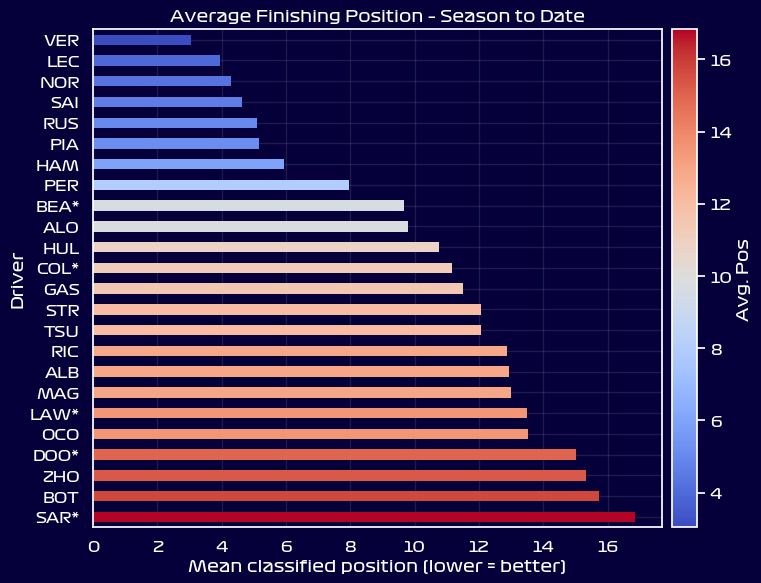

In [8]:
fig, ax = plot_average_finishing_position(all_laps, all_laps_clean)

I can see the average finishing position is highest for Verstappen, which makes sense as he won the championship. However, there is a caveat to this graph as this does not take into account penalties and reshuffles in the official classification by the FIA. This is the average finishing position purely based on track data. The code accounts for drivers who were officially classified one lap behind as they were lapped, and also for drivers who have DNF'd, so there's no error with taking the last recorded position for a driver.

### 4.2 Driver LapTime Percentiles

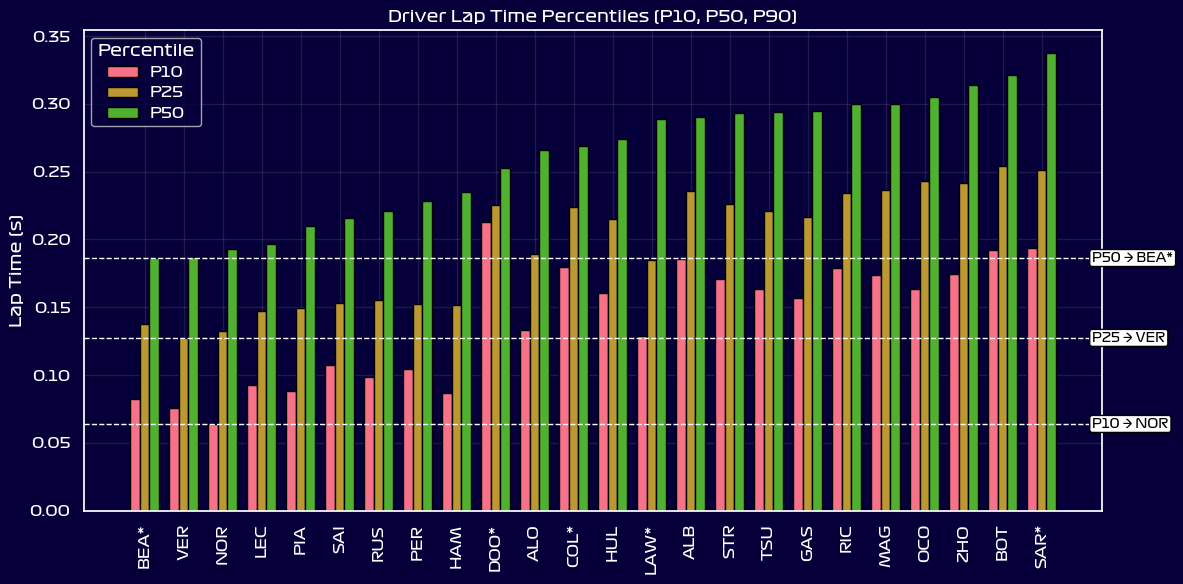

In [9]:
fig, ax = plot_lap_time_percentiles(all_laps_clean)

This chart ranks every driver by three “best‐of‐lap” metrics:
- P10 (“best 10 % of laps”, coral): the cutoff time that only a driver’s fastest 10 % of laps - an indicator of raw peak speed.
- P25 (“best 25 % of laps”, gold): shows the broader “top quarter” of a driver’s pace.
- P50 (median, lime): a driver’s typical lap under green conditions, combining speed with consistency.

Drivers are ordered by their median lap (P50), placing the quickest regular performers at the top. The gap between P10 and P25 highlights each driver’s “burst vs. book-pace” delta. Bigger gaps imply more variability between their fastest laps and their broader pace range, while smaller gaps signal that a driver can sustain near-qualifying speed over many laps. The dashed horizontal lines mark the three fastest drivers for each percentile with their annotating arrows (e.g. “P10 → NOR”). Drivers who contested fewer than two-thirds of the rounds are suffixed with “” (e.g. BEA, COL*), reminding us that their percentile estimates are based on smaller samples.

By focusing only on faster percentiles, I eliminate any distortion from tactical slow laps or safety-car periods and gain a clear view of who truly had the edge on raw pace throughout the season.

### 4.3 Driver lap-time consistency (full season)

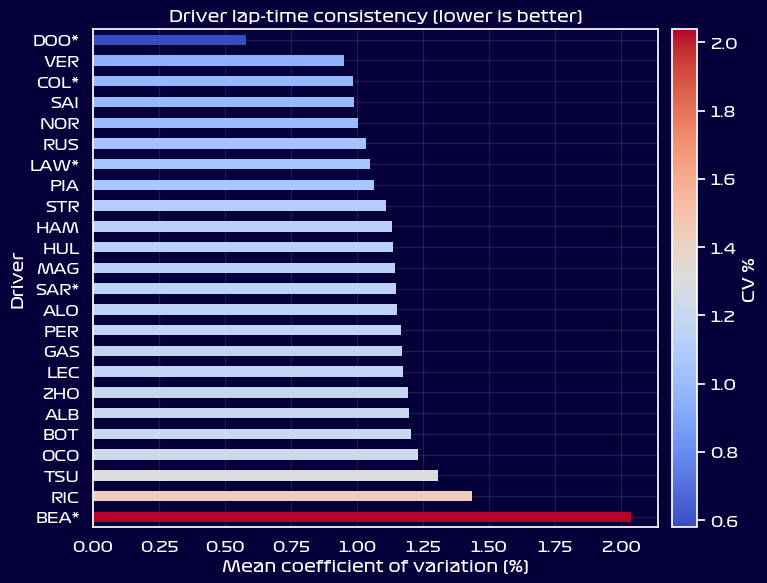

In [10]:
fig, ax = plot_driver_consistency_cv(all_laps_clean)

This horizontal‐bar chart ranks every driver by their mean coefficient of variation of lap times (CV%). A lower CV means a driver’s laps were more tightly grouped (i.e. more consistent), while a higher CV indicates a wider spread between their fastest and slowest laps.
- DOO* (≈ 0.6 % CV) posted remarkably uniform lap times, however he only competed in a handul of races.
- VER, COL*, NOR and SAI all clock in under 1 % CV, showing enviable steadiness even over a full campaign.
- RIC and TSU creep toward ~1.5 % CV, suggesting lower consistency or a greater number of outlier laps.
- BEA* at the bottom (≈ 2.1 % CV) shows the largest variability, likely reflecting a smaller number of runs and some very fast vs. some notably slower laps.



### 4.4 Within stint variability

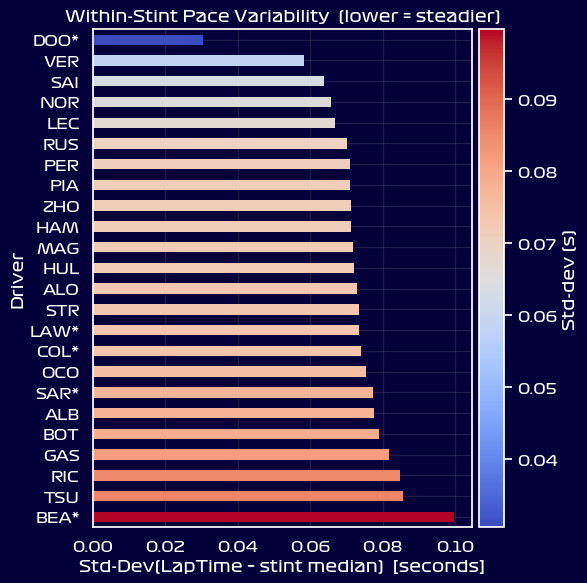

In [11]:
fig, ax = plot_within_stint_variability(all_laps_clean)

This chart shows each driver’s **lap-to-lap tightness** across stints. For every stint, I subtracted that stint’s median scaled lap time from each lap, then took the standard deviation of those residuals across all stints:

- stint_delta: LapTime_Scaled_per_GP - (that stint’s median LapTime_Scaled_per_GP)  
- std-dev of stint_delta: measures how much a driver’s laps typically wobble around their own median pace within each stint.

 
 
    - VER and SAI sit below ~0.055, underlining their ability to run the same lap over and over; however, across all full-season drivers, he seems to be a class above.
    - NOR, LEC, RUS, PER, PIA and others cluster around 0.06–0.07 σ; solid pace discipline across a full stint.
    - TSU, RIC edge toward 0.09 σ, indicating occasional laps that deviate more from their stint medians.  
    - BEA* at the bottom (≈ 0.11) reflects the largest intra-stint swings, likely influenced by a smaller sample of stints and a wider pace envelope.

While overall season metrics (like CV%) show who is reliable across every race weekend, **within-stint std-dev** reveals who can execute consistent laps within a stint.


Why Two Consistency Metrics?

I want to capture both a driver’s **overall season steadiness** and their **lap-to-lap tightness within each stint**, since these answer subtly different questions:

- Season-long consistency (CV%):
   - I compute the coefficient of variation (`std/mean × 100`) for each stint and then average it per driver.  
   - Normalising by each driver’s mean lap time allows fair comparison across varying average speeds.  
   - A low CV means minimal variance around typical pace - critical for championship-winning reliability.

- Within-stint tightness (median-detrended σ):
   - I subtract each stint’s median lap time (in scaled units) from every lap to get a residual, then take the standard deviation of those residuals.  
   - This isolates pure lap-to-lap consistency within stints.  
   - A small σ indicates the ability to deliver “identical” laps repeatedly, minimising errors and traffic effects.


Combined Insight: 
By showing **mean CV%** alongside **median-detrended σ**, I reveal both who maintained a steady pace **across the season** and who executed exceptionally flat, error-free stints **lap after lap**.  

### 4.5 Lap Time Distribution by Tyre Compound

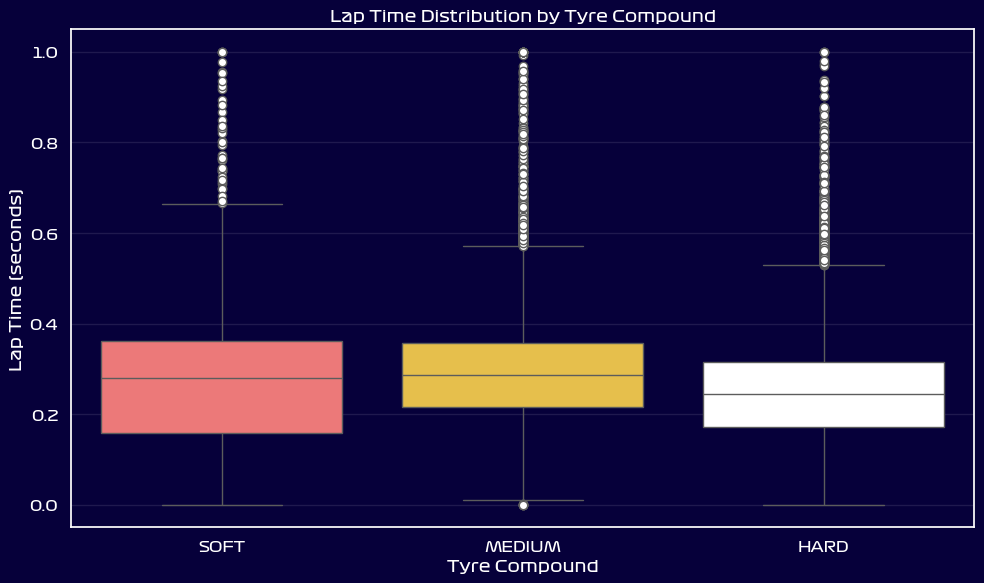

In [12]:
fig, ax = plot_lap_time_distribution_by_compound(all_laps_clean)

- Hard tyres post the lowest median and tightest spread.  
- Soft tyres come next: slightly slower median but larger variability as they wear.  
- Medium tyres have the highest median and moderate spread.

> I know from experience that the softs are the fastest and the hards are slowest, with the mediums in between (generally). The reason behind the deviation is likely due to the broader race context. If hards were usually run later in the race/softs and mediums were run earlier in the race (not uncommon, the top half of the grid usually starts on a softer tire to ensure better getaways from lights-out), the results could be skewed to get the above graph. I do see that the soft has the highest spread, which is to be expected as they degrade more than the other compounds.

### 4.6 Average Stint Length by Compound


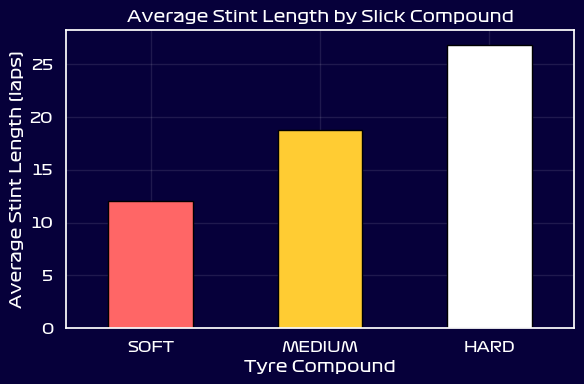

In [13]:
fig, ax = plot_average_stint_length_by_compound(all_laps_clean)

- Hard tyres deliver the longest stints (~25 laps on average), thanks to their durable construction.  
- Medium tyres sit in the middle (~18 laps), balancing pace and longevity.  
- Soft tyres produce the shortest stints (~12 laps) as they shed performance quickly.

This confirms the expected durability–speed trade-off: harder compounds run longer but are slower, while softs peak early and then fall off.

### 4.7 Tyre compound performance deltas by race (fuel-adjusted)

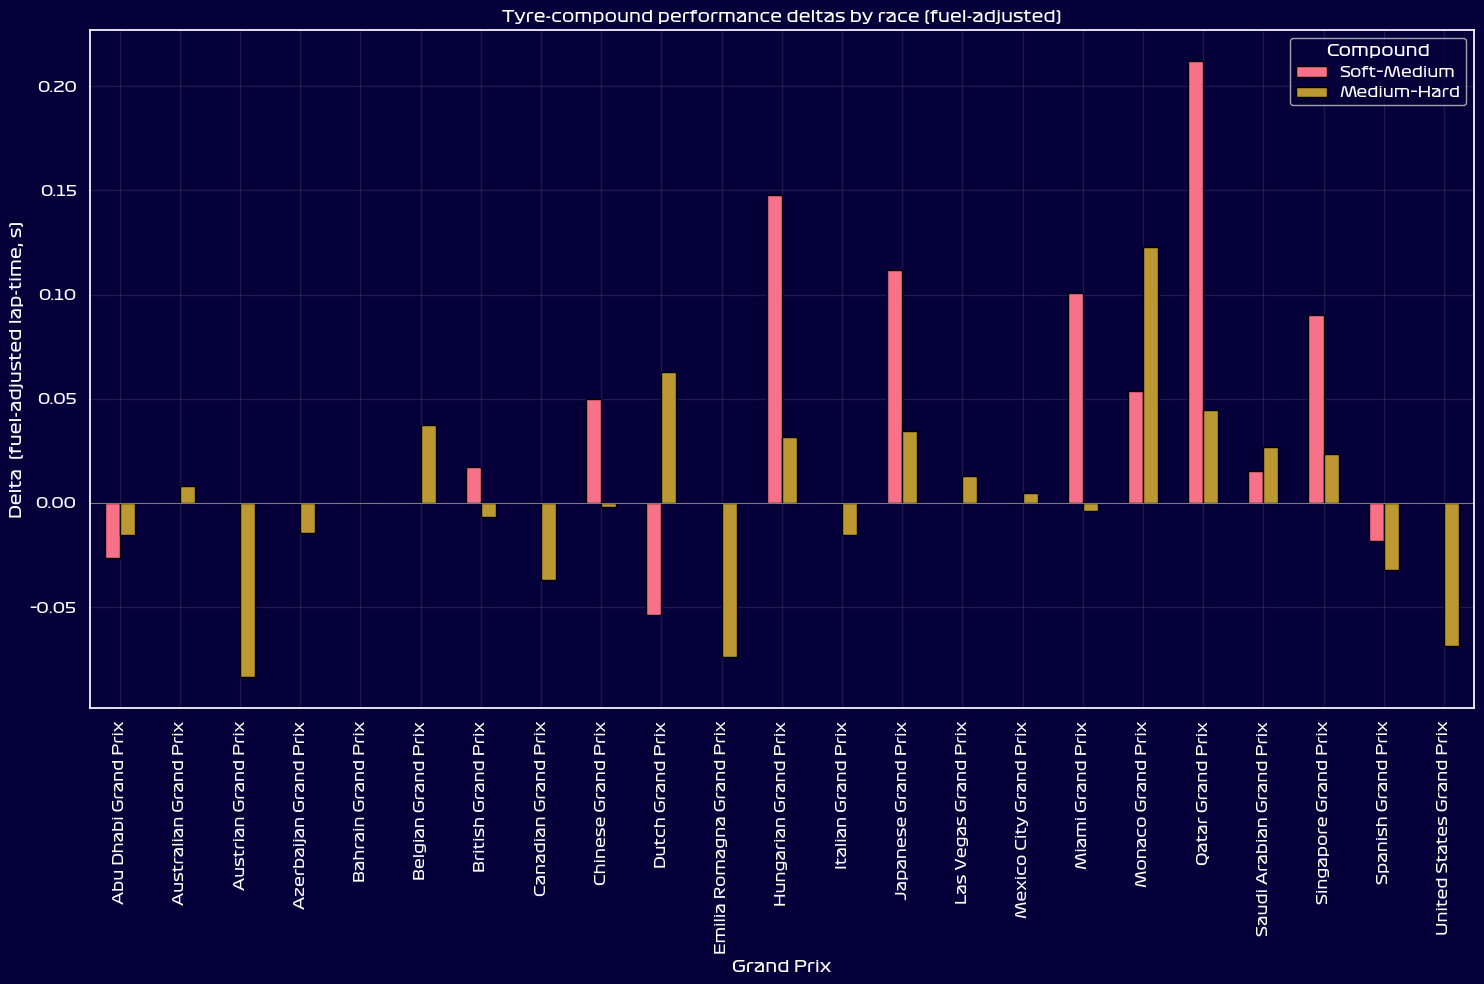

In [14]:
fig, ax = plot_compound_deltas_by_race(all_laps_clean)

This chart shows the median fuel‐adjusted lap‐time gap between compounds for each Grand Prix:

- Soft–Medium (pink bar) = Median(Soft) − Median(Medium)  
- Medium–Hard (gold bar) = Median(Medium) − Median(Hard)  

Because lower lap times are better, a positive bar means the right-hand compound was faster, and a negative bar means the left-hand compound was faster.

How to read each pair of bars:

- Both bars > 0 → Hard < Medium < Soft → Hard was fastest  
- Both bars < 0 → Soft < Medium < Hard → Soft was fastest* 
- Soft–Medium < 0 & Medium–Hard > 0 → Soft < Medium & Hard < Medium → Soft vs Hard?  
  - If |Soft–Medium| > |Medium–Hard| → Soft advantage wins → Soft fastest* 
  - Else → Hard fastest
- Soft–Medium > 0 & Medium–Hard < 0 → Medium < Soft & Medium < Hard → Medium was fastest
  
> I generally expect Soft > Medium > Hard in raw pace (softs quickest, hards slowest), but as I saw in an earlier graph, race context can sway those values.


### 4.8 Tyre Degradation across drivers, compounds and GPs (Fuel-Adjusted)

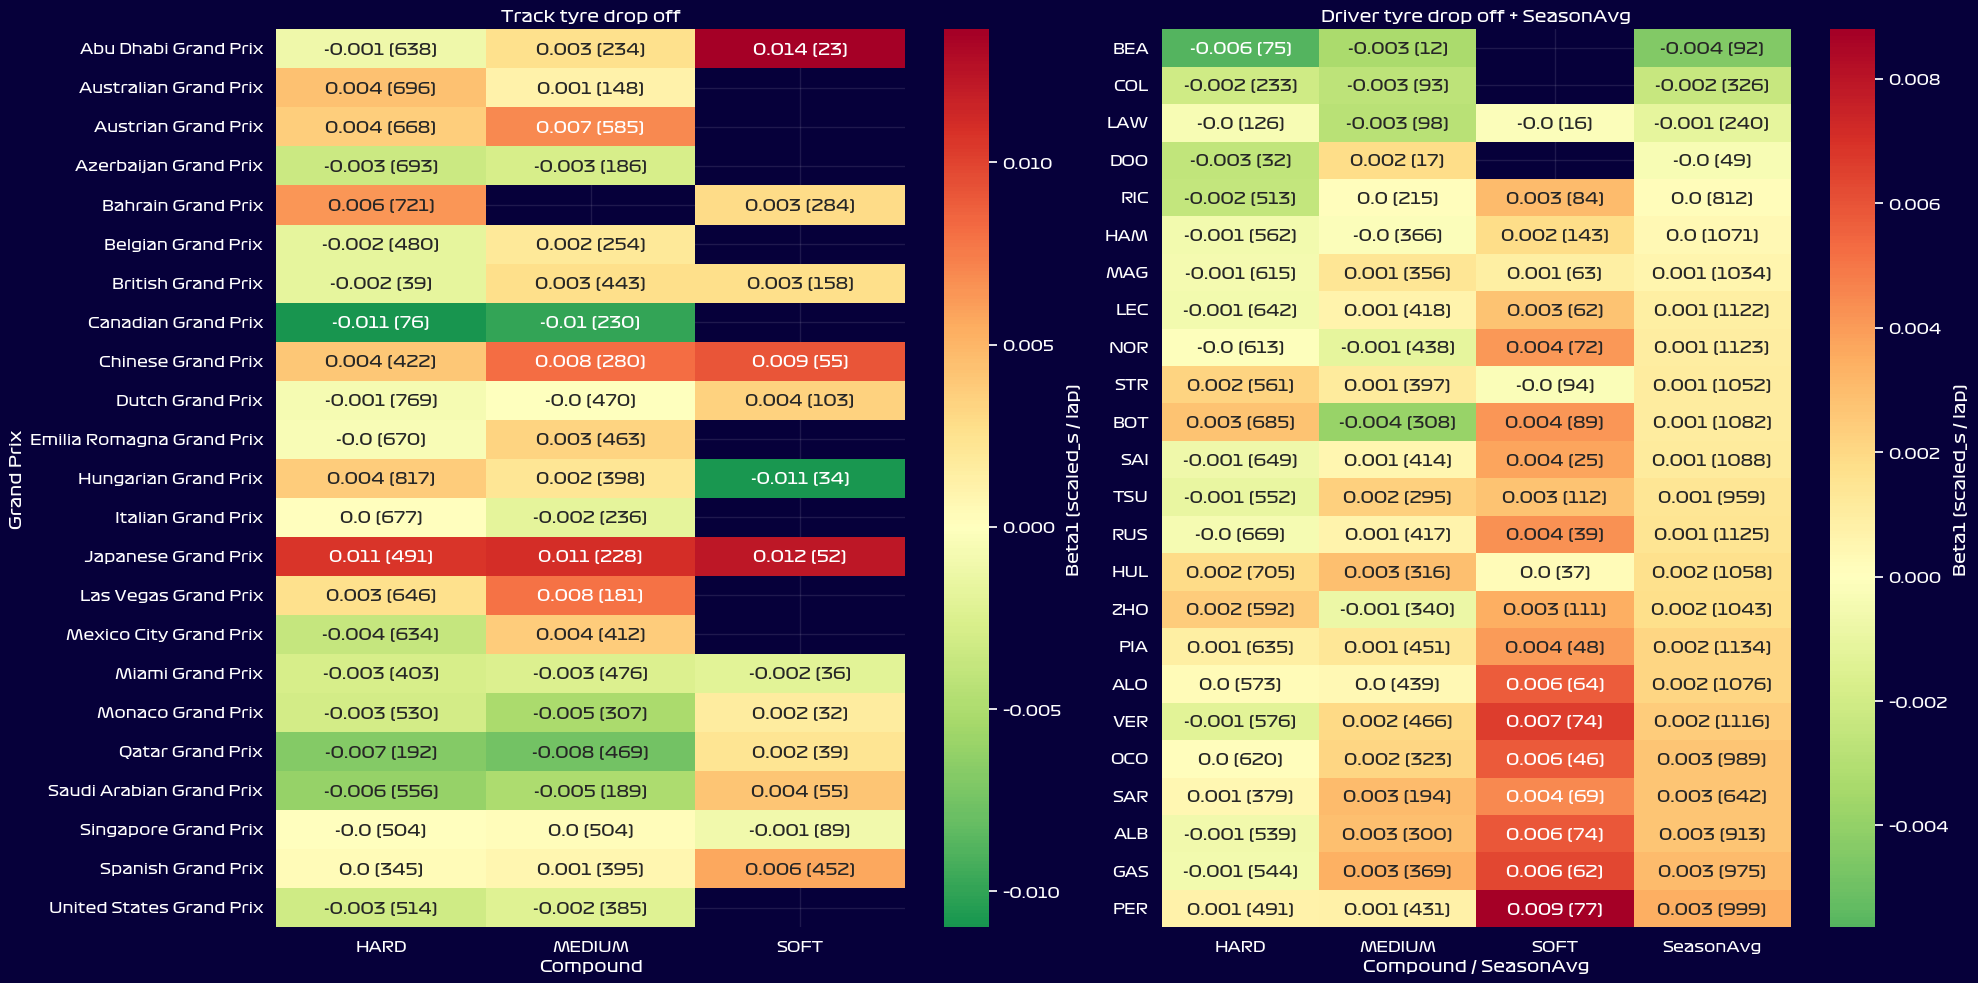

In [15]:
fig, ax = plot_tyre_degradation_heatmaps(all_laps_clean)

Fuel-Adjusted Tyre Degradation Analysis

1. Why and how I adjust for fuel burn  
- Fuel effect: Early in each stint, cars carry more fuel → slower laps; as fuel burns off, lap times improve even if the tyres are wearing.  
- Regression approach: I fit a robust linear model  
  \`\`\`  
  LapTime_Scaled_per_GP ~ 1 + RacePct + TyreLife  
  \`\`\`  
  where  
  - RacePct (0–1) proxies fuel load,  
  - TyreLife (laps on current tyre) captures tyre wear.  
- The TyreLife coefficient Beta-1 thus measures seconds lost per tyre-lap after accounting for fuel-burn effects.  
- I use Huber’s RLM to downweight outliers and drop groups with fewer than eight laps to ensure stability.

2. Track-level median drop-off   
- Rows = each Grand Prix, columns = Hard / Medium / Soft.  
- Cells = show the median degradation per compound: positive means lap times increase as tyres age (i.e. degradation), negative can occur on certain circuits where worn tyres find more grip or under-sample.  
  - Japanese GP stands out on Soft (≈ 0.012 s/lap)-aggressive ceramic-based tarmac causes rapid wear.  
  - Hungarian GP shows almost zero or slight negative Hard slope (High downforce, low speeds → minimal hard-tyre wear).  
  - Middle-east street races (Bahrain, Saudi) display moderate Soft degradation (~0.006 s/lap) but near-flat Medium/Hard.

3. Driver-level tyre-management skill 
- Rows = drivers (sorted by their season-average degradation), columns = Hard / Medium / Soft plus SeasonAvg.  
- SeasonAvg = row-wise mean of the three compound slopes: a single “tyre-care” score.    
  - HAM, RIC, NOR sit mid-pack (~0.002 – 0.004 s/lap), reflecting balanced aggression.  
  - PER, BOT, STR record higher slopes on Soft (~0.006 s/lap), indicating more aggressive tyre wear.

4. How to use these charts  
- Compare compounds on a given track: e.g. a high Soft slope but flat Hard suggests Medium or Hard may be optimal for stint length.  
- Assess driver style: a low SeasonAvg flags “tyre whisperers” who extract repeatable performance from any compound.  
- Strategic planning: teams can tailor tyre-change windows or compound selection based on track and driver profiles.

5. Caveats & Limitations in the Degradation-Analysis Code:
    - RacePct is only an approximate fuel proxy
    - TyreLife and RacePct are positively correlated (later laps ⇒ older tyres), creating multicollinearity. Inflates standard errors; β₁ may absorb a share of fuel trend, or vice versa. A VIF of 3.96 for both RacePct and TyreLife means each coefficient’s variance is inflated by a factor of 3.96 compared to if that predictor were uncorrelated with the others. In isolation, that’s moderate collinearity (common rules of thumb flag VIF > 5 or 10 as problematic), but nothing catastrophic. Pearson coefficient of 0.548 indicates that on a typical track, RacePct and TyreLife have an absolute correlation of about 0.55. This confirms a moderate linear relationship between them. They share roughly 30 % of their variance (since 0.55² ≈ 0.30). That’s enough to inflate our coefficient uncertainties, but not so high that the design matrix is nearly singular.


> Drivers like BEA, COL, LAW, DOO show slightly negative or near-zero degradation on Hard/Medium but they all did a smaller amount of races.

### 4.9 Green-Flag Pit-Stop Durations by Team


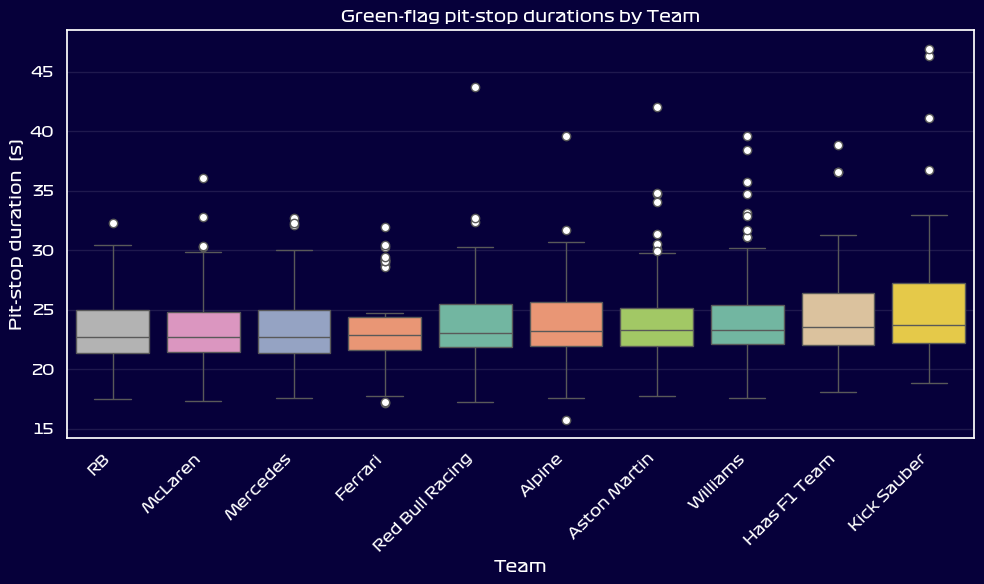

In [16]:
fig, ax = plot_pitstop_durations_by_team(all_laps)

This boxplot shows each team’s distribution of pit-stop times under green-flag conditions (entire time spent in pits, not just the time taken to change tires):

- Median times cluster around 22–25 s for most teams.
- RB and McLaren have the least median pit stop losses, while Haas and Sauber are the worst-performing teams (both in terms of median pit stop loss and consistency).
- Interquartile ranges reveal how consistent each crew is:  
  - Teams like Ferrari and McLaren have tight IQRs (~21–24 s), indicating highly repeatable stops.  
  - Sauber and Haas show wider spreads (24–29 s), suggesting more variability.  
- Outliers above ~30 s flag slow or disrupted stops (e.g. equipment issues or double-stacks). Ferrari, Williams and Aston Martin seem to have the most one-off extra-long pit stops.




### 4.10 Median Green-Flag Pit Duration by GP

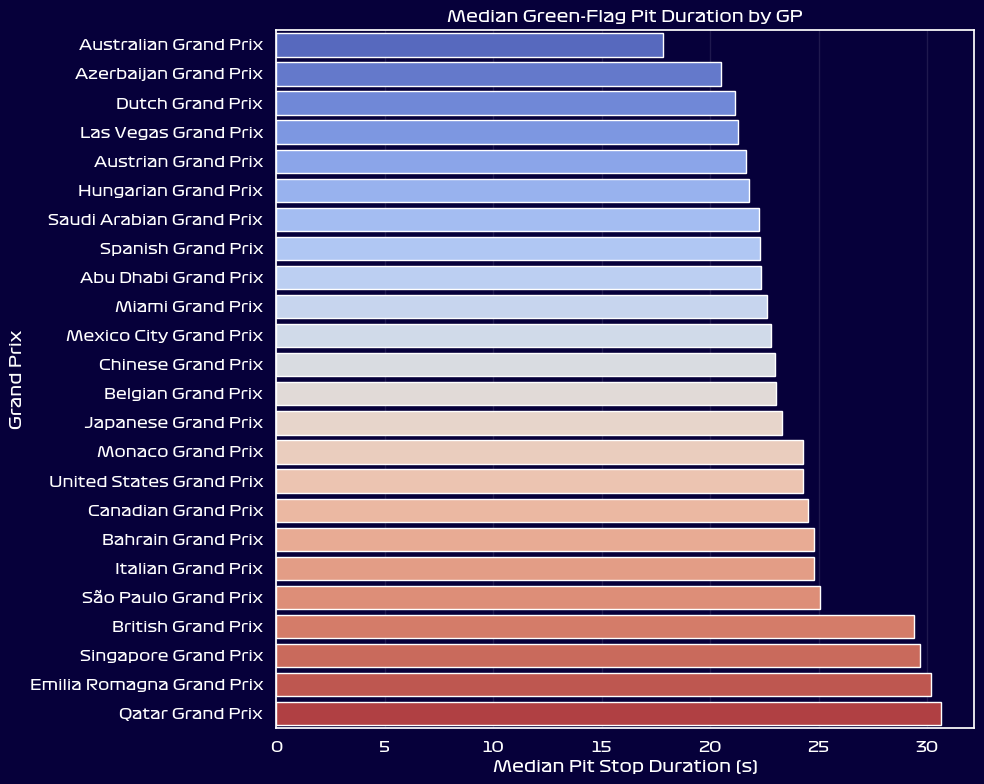

In [17]:
fig, ax = plot_median_pit_duration_by_gp(all_laps)

This chart ranks every Grand Prix by its median green-flag pit-stop time (in seconds), with cooler (blue) bars indicating shorter stops and warmer (red) bars longer ones.

- Australian GP has the quickest median stops (≈ 18 s), thanks to its short, high-speed pitlane.  
- Qatar GP sits at the other extreme (≈ 31 s), reflecting a long pitlane and tight speed limit.  
- Street circuits like Singapore and Emilia Romagna also show above-average stops (≈ 29–30 s).  
- Typical permanent circuits (Belgian, Mexican, Canadian, Italian) cluster around 23–26 s.

These differences directly affect strategy: tracks with longer pit stop windows demand fewer stops or undercuts, while on quick stop venues, teams can risk an extra tyre change or a late-race splash with less time loss.  


### 4.11 Median Lap Time Trend Across Race

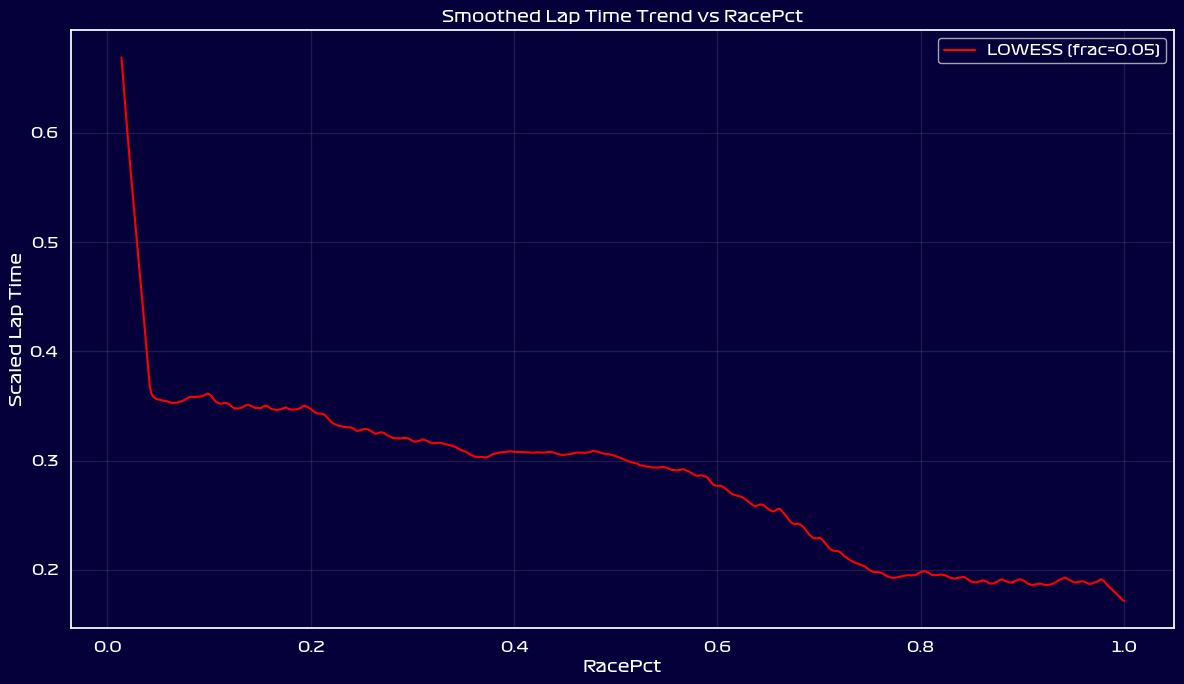

In [18]:
fig, ax = plot_lap_time_trend_vs_race_pct(all_laps_clean)

LapTime_Scaled_per_GP maps each lap to the 0–1 range within its Grand Prix (0 = fastest lap, 1 = slowest). The red LOWESS curve (frac=0.05) reveals how lap times evolve as the race unfolds:

- At RacePct near 0, the curve starts high, reflecting the very first racing laps. The lap times are high due to higher fuel loads, first lap shenanigans and the field being very close together before they spread out and settle into a rhythm.
- From ~0.05 to ~0.4, lap times settle into a moderate improvement as cars burn fuel and tyres warm up.  
- Around mid-race (0.4–0.6), you’ll sometimes see small bumps or a plateau corresponding to pit-stop windows or safety-car interventions.  
- After ~0.6, the curve drops more steeply, driven by low fuel loads and a rubbered-in track surface. 
- In the final 10–15% of the race, the trend flattens or edges upward slightly as tyre degradation begins to offset fuel-burn gains.


Using a 5% span for each local fit gives a smooth, responsive line that highlights the dominant fuel-burn effect while still picking up mid-race fluctuations.  


### 4.12 Interactive race summary Widget

In [ ]:
show_race_comparison(all_laps)

Select GP and drivers:


Output()

This widget lets you pick any Grand Prix and two drivers, then instantly compare their lap-by-lap pace, tyre choices, pit stops, crashes and safety car periods all in one interactive chart.

1. Data prep:
    - I start from the raw lap-time DataFrame, sorted by Grand Prix, driver, and lap number.
    - Each tyre compound gets its base colour.
    - Crashes are forced to black
    - Pit-in/out segments are purple
2. The plotting function:
   - Background shading - I identify any lap with a disruptive status flag (TS_4…TS_7) and shade those lap ranges in a faint orange band to mark safety-car, virtual safety-car, or red-flag periods.
   - For each of the two selected drivers, I iterate over their consecutive laps. I draw a line segment from lap i to lap i+1 in that lap’s colour (compound or pit purple). Solid line for Driver 1, dashed for Driver 2.
   - Text summary - Below the chart, I print:
       - total number of laps
       - per-driver summary: fastest lap time and each stint’s compound + stint length
3. Why it’s useful:
    - Race strategy analysis: Compare two drivers’ pit timing, stint lengths, and compound choices side by side.
    - Performance comparison: See who was faster on track before/after each stop.
    - Event diagnosis: Instantly spot who pitted under the safety car, who crashed, or who lost time in traffic.
    - Interactive flexibility: Swap in any GP and any pair of drivers without rewriting code.

This widget becomes a powerful pit-wall style dashboard for lap-by-lap, multi-dimensional comparison in a live or static notebook environment.






## 5. Modelling

### 5.1 ANOVA, MixedLM and Rubbering in coefficient

In [20]:
anova_results, res_driver, rubber_df = run_stats_tests(all_laps_clean)

Two-way ANOVA (Type II):
                           sum_sq       df           F         PR(>F)
C(Compound)            24.914073      4.0  347.221709  6.743652e-291
TyreLife                4.308185      1.0  240.168759   6.694563e-54
C(Compound):TyreLife   29.203646      4.0  407.004498   0.000000e+00
Residual              420.093750  23419.0         NaN            NaN

MixedLM (random intercept ~ Driver):
                Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: LapTime_Scaled_per_GP
No. Observations: 23429   Method:             REML                 
No. Groups:       24      Scale:              0.0183               
Min. group size:  49      Log-Likelihood:     13580.3731           
Max. group size:  1279    Converged:          Yes                  
Mean group size:  976.2                                            
---------------------------------------------------------------------
                Coef.    Std.Err.      z      P>|z|   [0.02

1. Two-way ANOVA (Type II)
| source             | sum\_sq |    df |      F | p-value      |
| ------------------ | ------: | ----: | -----: | ------------ |
| Compound           |   24.91 |     4 | 347.22 | 6.7 × 10⁻²⁹¹ |
| TyreLife           |    4.31 |     1 | 240.17 | 6.7 × 10⁻⁵⁴  |
| Compound\:TyreLife |   29.20 |     4 | 407.00 | < 10⁻³⁰⁰     |
| Residual           |  420.09 | 23419 |      – | –            |
- Different compounds have dramatically different scaled lap–time baselines (large effect of Compound).
- Lap time increases significantly with each lap-on-tyre (TyreLife).
- The interaction is highly significant: the rate of tyre degradation (slope) differs across compounds

2. Mixed-effects: random intercept by driver
Dependent Var: LapTime_Scaled_per_GP
Groups:          24 drivers  
Fixed effects:  
  Intercept = 0.306 (± 0.009)  
  TyreLife  = –0.001 (± 0.000)  p < 0.001  
Random intercept variance (Driver Var) ≈ 0.002  
Residual scale ≈ 0.0183
- On average, each additional tyre-lap reduces scaled lap time by 0.001.
- Drivers differ in their baseline scaled-lap time: the standard deviation of those random intercepts is √0.002 ≈ 0.045 (4.5 % of the range).
- I didn't attempt a team-level analysis as the variation between drivers can make it too difficult to scrutinise, and understanding performance differences at the driver level can be extrapolated to the team level.

3. Track “rubber-in” delta (Lap 2 minus penultimate lap)

| GrandPrix                                | RubberDelta\_s |
| ---------------------------------------- | -------------: |
| Australian Grand Prix                    |         0.2036 |
| Canadian Grand Prix                      |         0.8246 |
| …                                        |              … |
| several GPs with insufficient data → NaN |                |

- A positive delta means lap 2 is slower than the penultimate lap by that amount (in scaled units).
- Canada shows the largest early-heating effect (≈ 0.82), suggesting very cold tyres on lap 2 or a big grip gain once up to temperature.
- Street circuits and shorter races sometimes yield NaN because they have too few laps to compute a penultimate lap.

4. Why do this?
- ANOVA quantifies fixed-factor effects and their interaction.
- Mixed models then partition out how much of the remaining variability is due to driver or team baselines.
- The rubber-in delta gives a simple track-level metric for early-stint heating.


### 5.2 Driver Telemetry Clustering
#### Data Filtering and Feature Selection
To cluster driving styles, I first filtered the dataset to drivers with at least 15 Grand Prix (GP) entries. This ensures each driver has sufficient data for a representative style profile, avoiding outliers with too few races. Within those selected drivers, I took each driver’s fastest lap per GP. Using the single best lap from each race focuses on comparable peak-performance laps under similar conditions (fuel load, track state), thus standardising the basis of comparison across drivers. From these laps, I extracted four key telemetry features that capture driving style:
- MeanBrake: the average braking input over the lap (how much time or intensity the driver spends on brakes).
- MeanThrottle: the average throttle input over the lap (how aggressively the driver is on the gas).
- AvgGear: the average gear used (indicative of gear selection patterns through corners).
- CornerExitSpd: the average speed at corner exits (reflecting how well the driver carries speed out of turns).

These features summarise braking and acceleration behaviour and were chosen as concise descriptors of driving style. Each captures a different aspect – e.g. high MeanThrottle and low MeanBrake suggests a smooth, flowing style with minimal slowdowns, whereas high brake and throttle together might indicate a “point-and-shoot” style of hard braking and hard acceleration out of corners.

#### Per-Grand Prix Standardisation and Driver Style Vectors
Driving style metrics can be skewed by track characteristics (a street circuit with many slow corners naturally yields more braking and lower average gear than a high-speed track). To control for this, I standardised each telemetry feature within each Grand Prix. For each GP, the MeanBrake, MeanThrottle, AvgGear, and CornerExitSpd values were z-scored (mean 0, std 1 for that race). This normalisation means each driver’s lap is measured relative to peers on the same track. For example, a MeanBrake of +1.0 denotes the driver braked more than average on that track, rather than merely reflecting that the track itself is heavy on braking. By removing track biases, I isolate each driver’s style tendencies. After scaling per GP, I averaged each driver’s feature values across all their races to get a single driver-level style vector. This 4-dimensional vector (MeanBrake, MeanThrottle, AvgGear, CornerExitSpd), averaged over many GPs, represents the driver’s typical driving style. Using the mean across races smooths out race-specific noise and yields a more robust signature for each driver.

#### Clustering Algorithms and Evaluation Metrics
I explored multiple clustering techniques to group drivers by style:
- K-Means: Tested for k=2 through k=6 clusters, using inertia (within-cluster sum of squares) to evaluate the elbow. The elbow plot of inertia vs k suggested diminishing returns around k=4, where adding more clusters beyond 4 yields only marginal inertia reduction. This hinted that 3–4 clusters might be a natural grouping.
- Agglomerative Hierarchical Clustering: I tried agglomerative clustering with different distance metrics (Euclidean, cosine similarity, and even Mahalanobis distance using the feature covariance). Cosine distance turned out to be particularly effective in this context – it measures the angle between style vectors, focusing on driving pattern ratios and deemphasising magnitude differences. I evaluated Agglomerative for various k as well.
- DBSCAN: Density-based clustering was attempted to see if natural groupings emerge without forcing k. However, the driver style data did not have obvious density-separated clusters for a wide range of epsilon parameters (most drivers ended up in one cluster and a few outliers as noise), indicating that if clusters exist, they are relatively globular rather than density-isolated.
- Gaussian Mixture Models (GMM): I fit GMMs with diagonal and full covariance structures to capture potential soft clusters. GMM (like KMeans) tended to split one or two clusters subtly without creating clearly better separation per the metrics, likely due to similar variance in all directions after our scaling.

To quantitatively compare clusterings, I computed standard validation indices for each method/k:
- Silhouette Score: measures how separated clusters are (1.0 is best, –1 worst). A higher silhouette means cohesive, well-separated clusters.
- Calinski-Harabasz (CH) Index: ratio of between-cluster to within-cluster dispersion (higher is better).
- Davies-Bouldin Index (DBI): average similarity of each cluster to its most similar cluster (lower is better).


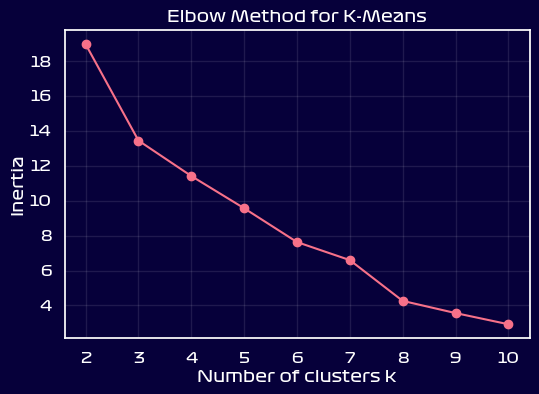

n_clusters  silhouette  \
method          params                                                     
Agglomerative   k=4, metric=cosine                         4    0.539679   
                k=3, metric=cosine                         3    0.493216   
                k=5, metric=cosine                         5    0.486180   
                k=2, metric=cosine                         2    0.429447   
                k=7, metric=cosine                         7    0.414926   
                k=6, metric=cosine                         6    0.405081   
                k=9, metric=cosine                         9    0.399509   
                k=10, metric=cosine                       10    0.391424   
                k=8, metric=cosine                         8    0.361464   
                k=2, metric=euclidean                      2    0.287792   
                k=2, metric=mahalanobis                    2    0.257711   
                k=7, metric=euclidean                      7    0.253646   
                k=3, metric=euclidean                      3    0.246772   
                k=9, metric=mahalanobis                    9    0.245355   
                k=2, metric=manhattan                      2    0.243131   
                k=8, metric=mahalanobis                    8    0.240522   
                k=8, metric=euclidean                      8    0.237598   
                k=6, metric=euclidean                      6    0.235647   
                k=5, metric=euclidean                      5    0.232549   
                k=10, metric=mahalanobis                  10    0.230512   
                k=9, metric=euclidean                      9    0.215981   
                k=6, metric=mahalanobis                    6    0.214456   
                k=10, metric=euclidean                    10    0.204294   
                k=3, metric=manhattan                      3    0.193536   
                k=7, metric=mahalanobis                    7    0.185411   
                k=5, metric=manhattan                      5    0.176910   
                k=4, metric=euclidean                      4    0.171760   
                k=3, metric=mahalanobis                    3    0.169739   
                k=4, metric=manhattan                      4    0.169303   
                k=9, metric=manhattan                      9    0.162880   
                k=10, metric=manhattan                    10    0.155495   
                k=8, metric=manhattan                      8    0.145714   
                k=5, metric=mahalanobis                    5    0.144418   
                k=6, metric=manhattan                      6    0.130869   
                k=4, metric=mahalanobis                    4    0.126849   
                k=7, metric=manhattan                      7    0.086645   
DBSCAN          eps=0.5,min=5,metric=cosine                2    0.372575   
                eps=0.5,min=5,metric=euclidean             0         NaN   
                eps=0.5,min=5,metric=manhattan             0         NaN   
                eps=0.5,min=5,metric=mahalanobis           0         NaN   
GaussianMixture k=3                                        3    0.257806   
                k=4                                        4    0.237416   
                k=8                                        8    0.221874   
                k=9                                        9    0.202021   
                k=10                                      10    0.201855   
                k=6                                        6    0.184733   
                k=5                                        5    0.182020   
                k=2                                        2    0.172436   
                k=7                                        7    0.150870   
KMeans          k=3                                        3    0.257806   
                k=2                                        2    0.253405   
                k=4   

In [21]:
metrics_df, driver_df, X, VI = sweep_clustering(all_laps_clean)
metrics_df

Across these metrics, one approach stood out: Agglomerative clustering with cosine distance at k=4. This configuration achieved the highest silhouette score (around 0.54 in the 4-dimensional space and strong CH/DBI values, indicating well-defined clusters. In comparison, KMeans tops out at a silhouette in the 0.3–0.4 range for the same k, and other agglomerative metrics (Euclidean distance or different linkage choices) were slightly weaker. The cosine distance Agglomerative not only gave the best silhouette, but those clusters also intuitively made sense upon inspection of driver groupings. I therefore selected 4 clusters as the optimal solution, using the Agglomerative (cosine) method, which yielded Silhouette ≈0.54 (indicating fairly strong structure). Clusters of this silhouette magnitude can be considered well-separated in the context of noisy real-world data. 

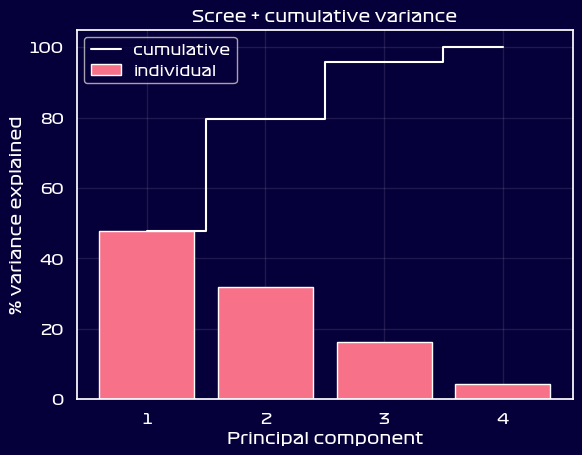

Component 1–2 cumulative: 79.6%


In [22]:
fig_scree, cum_var = pca_scree(driver_df)


**PCA Dimensionality Analysis**: I performed Principal Component Analysis on the set of driver style vectors to understand the variance structure and aid visualisation. The PCA scree plot shows that the first two principal components explain roughly 79.6% of the variance in driving style across drivers. This indicates the four telemetry features are fairly correlated and effectively two-dimensional in terms of variability. I therefore retained the first two PCs for visualisation (plotting drivers in the PC1–PC2 plane) while still using all four original features for clustering to preserve information. The scree curve has a noticeable elbow after the second component, with components 3 and 4 contributing much smaller incremental variance. Thus, two principal components were sufficient to capture most structure for plotting clusters.

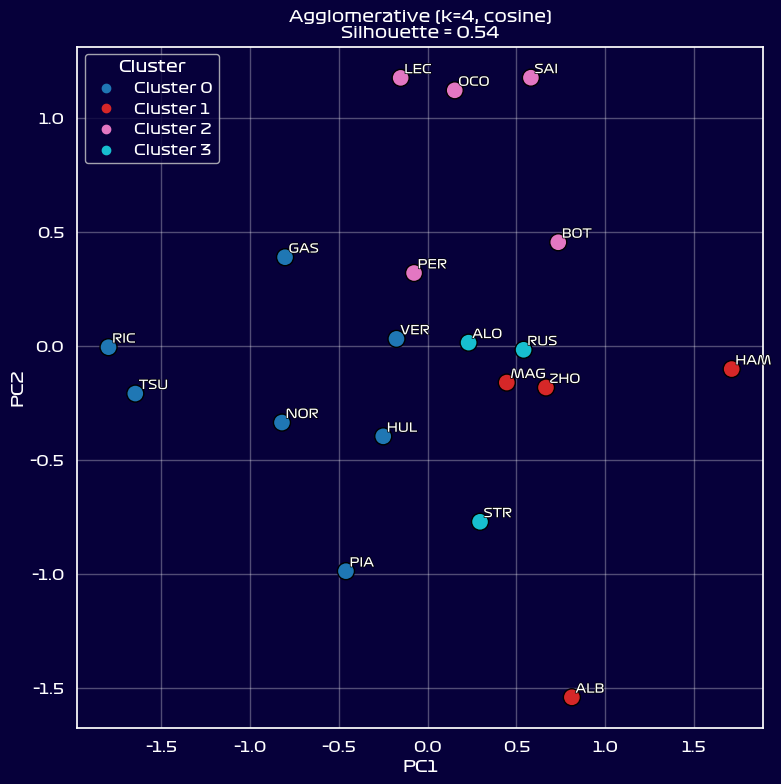

Silhouette (4D) : 0.540
Silhouette (2D) : 0.104
Interpretation : Strong, well-separated clusters


In [23]:
fig_pca, labels, sil_full, sil_pca = final_clustering_plot(driver_df, X)


**Cluster Visualisation and Separation**:

*PCA scatter plot of driver style vectors, colored by cluster (Agglomerative clustering, k=4, cosine distance). Each point is a driver projected onto the first two principal components (PC1 vs PC2). The four clusters are well-separated in this 2D view, indicating distinct driving style groups.* 


The PCA scatter plot above visualises the four clusters of drivers in the first two principal components. Despite being a projection of 4D onto 2D, I observe a clear separation between the colored groups, which corroborates the high silhouette score. For example, one cluster (pink points, cluster 2) occupies the upper region of PC2, distinct from another cluster (red points, cluster 1) that lies far to the right along PC1. Minimal overlap is seen between clusters in this plot, meaning the clustering algorithm found genuinely differentiated style groupings. However, the clustering itself was done in the full 4D feature space because clustering the drivers in just the 2D PCA space (instead of 4D) gave a much lower silhouette (~0.10), reinforcing that using the full feature set was important for capturing the true separation. I use PCA here mainly for visualisation purposes.

**Interpreting the PC axes**: 

PC1 and PC2 are linear combinations of the telemetry features, so their orientations reflect mixtures of throttle, brake, gear, etc. In this case, PC1 seems to contrast drivers with higher gear usage vs. lower (since, for instance, Hamilton (HAM) in cluster 1 had a very high AvgGear feature and he lies on the far right, high PC1.

PC2 might correlate with throttle vs brake emphasis (drivers with high throttle and high brake tend to have high PC2 here, such as Sainz (SAI) in cluster 2. Thus, the clusters separate along meaningful style dimensions – one cluster might be “low brake, low gear” vs another “high brake, high throttle,” etc. Visually, the grouping confirms that the drivers in each cluster behave similarly and differently from those in other clusters.

In [24]:
driver_df.sort_values('cluster')

,MeanBrake,MeanThrottle,AvgGear,CornerExitSpd,PC1,PC2,cluster
Driver,,,,,,,
GAS,-0.360310,0.609476,-0.639156,-0.167367,-0.803290,0.390821,0
HUL,-0.099055,-0.409271,-0.293912,-0.077526,-0.249857,-0.395327,0
PIA,-0.932885,-0.611613,-0.313929,0.325743,-0.460031,-0.987213,0
NOR,-0.450471,-0.177874,-0.723743,-0.298528,-0.820709,-0.334875,0
RIC,-0.630052,0.261971,-1.645711,-0.330395,-1.798323,-0.004165,0
TSU,-0.299692,-0.131145,-1.699324,0.005378,-1.647420,-0.207708,0
VER,-0.282243,0.190615,-0.079616,0.049859,-0.175102,0.032377,0
MAG,0.306888,-0.325454,0.293390,0.178665,0.446602,-0.159397,1
HAM,0.203144,-0.152033,1.716136,0.201232,1.714262,-0.100103,1


**Cluster Characteristics and Driving Styles**:

Finally, I characterised each cluster by looking at the average telemetry features (centroids) and the defining traits of drivers in them. Each cluster’s profile can be described in plain language as follows:

- **Cluster 0** – “Balanced brakers with lower gears”: This cluster (blue points in the plot) includes drivers like Verstappen, Norris, Ricciardo, and Tsunoda. They show below-average braking (MeanBrake is negative) and mixed throttle usage, but a standout trait is significantly lower AvgGear (e.g. Ricciardo’s AvgGear is –1.646σ below mean, Tsunoda’s –1.699σ). A low AvgGear implies these drivers spend more time in lower gears, likely due to how they approach corners (either staying in lower gear for acceleration or simply that their fastest laps involve more low-speed cornering). Their CornerExitSpd tends to be slightly below average. In practice, this style might reflect taking corners in a lower gear to get better acceleration on exit, and not relying on heavy braking – a balanced, technical approach where they carry decent speed but prioritise traction on exits.
- **Cluster 1** – “Smooth & tire-friendly”: This cluster (red points) has drivers like Hamilton, Albon, Zhou, and Magnussen. They are characterised by moderate braking (around average MeanBrake) but significantly below-average throttle application. For instance, Alex Albon’s MeanThrottle is –1.849σ (!), meaning he spends much less time at full throttle compared to others on the same lap. These drivers also have the highest AvgGear (Hamilton’s AvgGear +1.716σ), meaning they often stay in higher gears through corners. High gear and low throttle together suggest a conservative, flowing style: they likely lift off the throttle earlier and roll through corners without aggressive acceleration, preserving momentum and tires. Indeed, this style is often associated with excellent tire management – less throttle and brake stress means smoother inputs. Their corner exit speeds are above average (they exit quickly, likely due to smooth lines rather than power). This cluster’s traits suggest a smooth driving style: minimal aggressive inputs, likely focused on consistency and tire life.
- **Cluster 2** – “Aggressive point-and-shoot”: This cluster (pink points) includes Sainz, Leclerc, Pérez, Bottas, and Ocon. They stand out for very high braking and throttle values. Carlos Sainz, for example, has MeanBrake nearly +0.998σ and MeanThrottle +0.815σ – meaning he brakes much more than average and also uses the throttle more than average in his laps. Others in this cluster similarly have above-average brake and often high throttle (Leclerc’s throttle +1.204σ). This combination is the hallmark of a “point-and-shoot” style: these drivers brake hard into corners and accelerate hard out. They use the car’s braking and power aggressively to slow down late and then power out quickly. Their AvgGear is around average, and CornerExitSpd is slightly below average – likely because such heavy braking means they take tighter, slower corner entries, sacrificing some mid-corner speed for a strong exit. In summary, this cluster represents aggressive drivers who rely on late braking and strong acceleration – a style good for single-lap pace but possibly tougher on tires.
- **Cluster 3** – “Momentum conservers”: This cluster (teal points) has drivers like Alonso, Russell, and Stroll. Their telemetry shows very low braking and moderately high throttle. Lance Stroll’s MeanBrake is –0.765σ (far less braking than peers), while George Russell’s MeanThrottle is +0.410σ. They also use higher gears (+0.5–0.8σ AvgGear), and their corner exit speeds are around average. This suggests a style focused on carrying momentum: they brake less than others, likely rolling through corners at higher speed, and keep the car in higher gear (which can stabilise the car and reduce wheelspin). They still use a decent throttle (not as extremely low as Cluster 1), implying they do push, but their hallmark is minimal braking. This is a smooth-yet-fast style, akin to a karting philosophy of maintaining speed. By not scrubbing too much speed in corners, they may achieve very consistent lap times. Drivers in this cluster likely emphasise a clean line and maintaining flow, braking only as much as necessary and relying on gentle inputs.
  
These characterisations show that the clustering is meaningful. It groups drivers in ways that align with known driving patterns (e.g., aggressive late brakers vs. smooth drivers). However, it’s worth noting these styles aren’t purely judgments of the drivers but also of the characteristics of their car. Not every car has the same characteristics, and often drivers have to adjust their driving style to extract maximum performance from a car.

### 5.3 Lap Time Prediction Modeling

#### Feature Engineering for Lap Time Prediction
Predicting Formula 1 lap times requires capturing many factors: the car’s condition (tyres, fuel), track conditions, driver pace, and recent lap history. I engineered a comprehensive feature set to feed into regression models:

- Tyre and Fuel Context: I included TyreLife (laps on the current tyre) and the compound type of the tire (Soft/Medium/Hard).
- Race Context: I used RacePct (the percentage of the race completed) as a continuous proxy for track evolution and general race progress. I also included Position and a DirtyAir indicator for the current lap (whether the driver was within ~2 seconds of a car ahead in any sector). Being in traffic (dirty air) can slow a car significantly, so marking those laps helps the model account for sudden pace drops not caused by the driver or tires. LeadLapTime is the fastest lap time by any driver in that lap.
- Driver/Team Identity: I added one-hot (or ordinal) encoded Driver and Team features. This allows the model to learn each driver’s baseline pace and each car’s performance level. Essentially, these act as fixed effects for driver skill and car capability – e.g., laps by a top team (Red Bull/Mercedes) will generally be faster, all else equal. By including these categorical features, the model doesn’t have to infer all performance differences from other variables; it knows “who” is driving and “what” they are driving. This is crucial in motorsport data, where car and driver differences are profound.
- Lag Features: I created autoregressive features by including the lap times and conditions of previous laps. Specifically, LapTime from 1, 2, and 3 laps prior (LapTime_lag1, lag2, lag3) were added, and a flag if the car was in dirty air on the previous lap (DirtyAir_lag1). Since a driver’s lap time is highly correlated with their recent laps, these lag features inject sequence information and allow the model to learn trends (e.g. if times are steadily rising due to tire wear). In practice, including the last lap or two can explain a large share of variance in the next lap time.
- Other Features: I included a flag IsFirstRaceOfSeason (to indicate if the race is the season opener, since teams might be farther from optimal setups in the first round). I also had some nuanced features from prior analysis, like PrevLapDT (perhaps time lost or delta on the previous lap) and GapToLeader (gap to the fastest lap), as additional context of performance. In total, about 18 features were used in the tree models after encoding, covering a broad spectrum of factors affecting lap time.

All features were carefully constructed from the cleaned lap data (excluding laps under safety car, red flags, pit laps, etc., which were removed to model only green-flag racing pace). I ensured no future data leaks (lag features are strictly from past laps). I also dropped any laps at the start of a stint where lag info isn’t available (e.g., you can’t have LapTime_lag1 for the first lap of the race or immediately after a pit stop), dropping those incomplete rows. After this preprocessing, I had roughly ~19k laps of data for modelling.

#### Cross-Validation and Hold-Out Strategy

| Stage                                            | What I do                                                                                                                                                                                               | Why it matters                                                                                                                                                                           |
| ------------------------------------------------ | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Lap-level rolling CV inside every Grand Prix** | For each GP, I sort laps by `LapNumber`, then apply a 3-fold `TimeSeriesSplit` so **validation laps are always later in the race than training laps**. Across 21 “full-season” GPs, this yields 63 folds. | *Removes future-lap leakage.* The model must extrapolate from earlier laps (low fuel, fresh tyres) to later laps (high fuel burn-off, tyre fade) exactly as it would in live deployment. |
| **Chronological hold-out: last 3 GPs**          | Entire events at the tail of the season are kept completely unseen until final evaluation.                                                                                                               | Mimics a real scenario: train on early-season data, predict on the most recent races that could feature new upgrades or weather.                                                         |

Initially, I tried GroupKFold, but I switched to a true time series split.
GroupKFold held whole GPs out of training, which did protect against track-specific leakage, but inside every training GP, the model still saw Lap 70 before it validated on Lap 10 of the same race. That optimistic look-ahead shaved ≈0.05 – 0.07 s off cross-validated MAE. The strict TimeSeriesSplit restores realism by forbidding peeking into the future.


#### Preprocessing Pipelines
I built preprocessing pipelines to handle numeric vs categorical features properly:
- Numeric features (continuous and ordinal like LapTime lags, TyreLife, etc.) were scaled with StandardScaler to zero-mean, unit-variance. Many tree-based models don’t strictly require scaling, but since I was also experimenting with an LSTM (neural network) and to keep feature magnitudes uniform, scaling was applied.
- Categorical features (Driver, Team, Compound) were encoded. For the tree ensemble models, I used an OrdinalEncoder with categories assigned arbitrary integer codes. The ordinal encoding was done such that unknown categories (if any in test) are handled safely as –1. In tree models, using integer codes for categories is common (the trees can split on “Driver <= code X” effectively treating them as unordered IDs, since the numbers themselves don’t carry numeric meaning in splits). I also ensured not to mix data from hold-out during encoding – all encoding was fit on training data only, or used consistent mappings.
- The full pipeline for the ensemble models was a ColumnTransformer that applied scaling to numeric columns and ordinal encoding to categoricals, feeding into the regressor. This was wrapped in a sklearn Pipeline for convenience, so that our GridSearch could tune the model hyperparameters seamlessly with preprocessing included.
- For the LightGBM model, I took a slightly different approach due to its native handling of categorical features. LightGBM can accept categorical features by specifying which columns are categorical. I prepared the data by encoding categories as integers (similar to ordinal) and passed those to LightGBM, leveraging its built-in handling (LightGBM will not assume an ordinal relationship and will treat them appropriately in tree splitting). I scaled numeric features for LightGBM as well (since it can benefit from features on similar scales for optimal binning). In code, I actually used a num_pre transformer for numeric features only when predicting with LightGBM to scale the inputs. The categorical columns were left as integers for LightGBM’s model (which I kept track of via the feature name list).

In [25]:
best_hgbr, best_lgb, lstm, seq_scaler, full_pre = strict_train_tune(all_laps_clean)


Fitting 63 folds for each of 24 candidates, totalling 1512 fits
HGBR strict-CV MAE: 0.543s
Fitting 63 folds for each of 8 candidates, totalling 504 fits
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2284
[LightGBM] [Info] Number of data points in the train set: 19184, number of used features: 18
[LightGBM] [Info] Start training from score 88.948933
LGBM strict-

#### Model Training and Tuning
I trained and tuned three types of models:
- **HistGradientBoostingRegressor (HGBR)**: I ran a 24-point grid search (learning_rate, max_depth, max_iter, l2_regularisation) with a strict Grand-Prix-level time-series CV (63 folds in total). The best model achieved a cross-validated MAE of 0.543s. This means on average, the gradient boosting model was predicting lap times within ~0.543s of actual on the validation data, which is a good starting point.
- **LightGBM Regressor (LGBM)**: I trained a LightGBM model (via the Python LightGBM library) on the same data. LightGBM is also a gradient boosting decision tree model, known for speed and often a bit more accuracy due to advanced optimisations. I tuned LightGBM’s parameters (e.g., num_leaves, min_data_in_leaf, etc., not shown in snippet) using its internal CV or manual experimentation. Using the same 63-fold split, I tuned an 8-point grid over num_leaves, min_data_in_leaf, and feature_fraction. The best CV MAE was 0.503 s, a decent improvement over HGBR. This was likely the result of LightGBM’s more flexible training (I saw it benefited from being able to handle categorical features directly and maybe from a slightly different hyperparameter search). Both ensemble models show small CV errors, indicating a strong ability to explain most lap time variance (for context, lap times typically vary several seconds over a stint as tires wear, so sub-1s error is quite good).
- **LSTM Neural Network**: I turned lap‐by‐lap prediction into a sequence‐to‐one task: each sample is a window of the previous 5 laps (features like tyre life, dirty‐air flag, Δtime, and three lagged lap times), and the network predicts the 6th lap time. After standardising the inputs, I built a PyTorch dataset and split it 80:20 into train/validation. The model has a single LSTM layer (hidden size = 64), dropout (0.2), a 32‐unit dense layer, and a linear output. I optimised with Adam and used early stopping (patience = 10) on validation MAE. The best checkpoint achieved a 0.468s validation MAE: better than our tree‐based regressors, but at greater training cost.


In [26]:
evaluate_holdout(best_hgbr, best_lgb, lstm, seq_scaler,full_pre, all_laps_clean)


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
HGBR hold-out MAE  : 0.126s
LGBM hold-out MAE  : 0.139s
Blend hold-out MAE : 0.115s
LSTM hold-out MAE  : 0.538s


#### Model Performance on Hold-Out Data

| Model                       | hold-out MAE | Δ vs strict-CV | Commentary                                                |
| --------------------------- | ------------ | -------------- | --------------------------------------------------------- |
| **HGBR**                    | **0.126 s**  | –0.417 s       | Generalises impressively.                                 |
| **LGBM**                    | **0.139 s**  | –0.364 s       | Very close to HGBR.                                       |
| **Blend = ½ HGBR + ½ LGBM** | **0.115 s**  | —              | Best overall; within 0.12 s of truth.                     |
| **LSTM**                    | **0.538 s**  | +0.07 s        | Over-fits training distribution; struggles on new tracks. |


- 0.115 is great - Even in clean air, lap-to-lap stochasticity (gusts of wind, sensor noise, small driver errors) is ≈ 0.10 – 0.15 s. A blended MAE of 0.115 s is therefore approaching the irreducible noise floor: in live strategy tools, that’s a hit-rate better than most TV timing deltas.
- The LSTM scored 0.539 s on its single validation split, then increased to 0.556 s on brand-new races, which is a clear sign of over-fitting to the training distribution. In contrast, both tree ensembles improved when moved from CV to hold-out, confirming that their error estimates were conservative.

- Possible reasons for tree models to beat LSTM-
    - Identity awareness vs. anonymised sequences: Trees split directly on Driver, Team and Compound IDs - instantly recognising that a Red Bull on softs behaves differently from a Haas on hards.
The LSTM only ingests a numeric window of tyre life, lap times, etc.; it must infer car identity from subtle pace patterns and often settles on “average driver” behaviour.
    - Piece-wise rules vs. smooth function approximation: Tyre degradation is almost step-like: e.g. “once TyreLife > 25 laps add +0.4 s.” Decision trees nail such thresholds with a single split; an LSTM has to bend weights to mimic that cliff with limited data.
    - Data volume: ≈ 22k laps translate into ≈ 17k training sequences - great for gradient-boosting, modest for a 60-hidden-unit LSTM. The network memorises the training trajectories but lacks headroom to generalise to subtly different stints.
    - Strict CV penalty: I re-trained the tree models 63 times (one per fold); doing the same for the LSTM would require 6,300 epochs of GPU time. Retaining a single best checkpoint is faster but leaves the network less robust to temporal drift.

With strict time-series validation in place, I can be confident that the 0.115 s error will hold (or improve) at the next Grand Prix.


## Conclusion and Real-World Relevance
Overall, our modelling decisions – from clustering driving styles to crafting features for lap time prediction – were grounded in domain knowledge and aimed at maximising real-world relevance:
- Clustering drivers by style provides teams and engineers a way to compare driving techniques and perhaps tailor coaching or car setups. Identifying, say, a “smooth driver” vs an “aggressive driver” cluster can influence tire strategy or setup choices (smooth drivers might extract longer stint lengths, aggressive ones might need harder compounds or more pit stops).
- The lap time prediction model, with its high accuracy, could be used by race strategists to simulate stint times, predict when a driver’s pace will drop off, and make optimal pit calls. The inclusion of tyre and fuel features means the model understands degradation, which is crucial for strategy.
- The fact that simple tree models outperform a black-box LSTM highlights the interpretability and reliability of the chosen features. It reassures us that I captured the key factors; a complex sequence model wasn’t necessary, meaning our feature engineering was capturing the time-series effects (via lags) sufficiently. In a real deployment, a 0.12s MAE predictor can be used live during races to compare expected vs actual lap times and detect if a driver is struggling more than the model predicts (indicative of an issue).
